In [1]:
!pip install -q transformers sentencepiece

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import logging

# Reset Logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, handlers=[logging.FileHandler("system.log"), logging.StreamHandler()])
logger = logging.getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# LƯU Ý: Không để num_labels ở đây vì nó sẽ thay đổi theo từng Task
ARGS = {
    "data_dir": "/kaggle/input/preprocessed",
    "teacher_model": "ngcanh/sentiment-spam-phobert",
    "max_seq_len": 128,
    "batch_size": 32,
    "student_layers": 4,
    "student_hidden_size": 312,
    "epochs": 20, 
    "learning_rate": 3e-5,
    "temperature": 1.0,
}

# Load Tokenizer chung
tokenizer = AutoTokenizer.from_pretrained(ARGS["teacher_model"])

Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

In [3]:
class ViSpamDatasetMultiTask(Dataset):
    def __init__(self, data_path, tokenizer, max_len, task_type='task1'):
        self.df = pd.read_csv(data_path)
        self.df = self.df.dropna(subset=['clean_comment', 'label'])
        
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.task_type = task_type
        
        # Task 1: Label gốc (0, 1)
        if self.task_type == 'task1':
            self.labels = self.df.label.values.astype(int)
            print(f"[Task 1] Loaded {len(self.df)} samples.")
            
        # Task 2: Spam Label gốc (1, 2, 3) -> Map về (0, 1, 2)
        elif self.task_type == 'task2':
            self.df = self.df[self.df.label == 1].dropna(subset=['spam_label']).reset_index(drop=True)
            self.labels = self.df.spam_label.values.astype(int) - 1 
            print(f"[Task 2] Loaded {len(self.df)} samples (Spam only).")

        self.texts = self.df.clean_comment.values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_token_type_ids=True,
            return_attention_mask=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [4]:
class TinyPhoBERT(nn.Module):
    def __init__(self, teacher_config, student_layers=4, student_hidden=312, num_labels=2):
        super(TinyPhoBERT, self).__init__()
        self.config = AutoConfig.from_pretrained(ARGS["teacher_model"])
        self.config.num_hidden_layers = student_layers
        self.config.hidden_size = student_hidden
        self.config.num_labels = num_labels
        
        self.bert = AutoModelForSequenceClassification.from_config(self.config)
        self.fit_dense = nn.Linear(student_hidden, teacher_config.hidden_size)
        
    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert.roberta(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
            output_hidden_states=True, output_attentions=True
        )
        sequence_output = outputs.hidden_states
        logits = self.bert.classifier(sequence_output[-1])

        tmp_hidden = [self.fit_dense(hidden) for hidden in sequence_output]
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return {'loss': loss, 'logits': logits, 'hidden_states': tmp_hidden}

def soft_cross_entropy(predicts, targets):
    student_likelihood = F.log_softmax(predicts, dim=-1)
    targets_prob = F.softmax(targets, dim=-1)
    return (-targets_prob * student_likelihood).mean()

# --- ĐÃ XÓA PHẦN KHỞI TẠO MODEL Ở DƯỚI ĐỂ TRÁNH LỖI ---

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix # Import lại cho chắc

# 1. Định nghĩa Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha # Class Weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits, targets: labels
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# 2. Tính Class Weights cho Task 2
print("Calculating Class Weights for Task 2...")
df_train = pd.read_csv(f"{ARGS['data_dir']}/train.csv")
df_spam_only = df_train[df_train.label == 1].dropna(subset=['spam_label'])
y_spam_labels = df_spam_only.spam_label.values.astype(int) - 1 # 1,2,3 -> 0,1,2

classes = np.unique(y_spam_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_spam_labels)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

print(f"Task 2 Class Weights (0, 1, 2): {class_weights_tensor}")

Calculating Class Weights for Task 2...
Task 2 Class Weights (0, 1, 2): tensor([5.9668, 1.1414, 0.5112], device='cuda:0')


In [6]:
# --- 1. HÀM TRAIN DISTILL ---
def train_distill(student, teacher, dataloader, optimizer, scheduler, epoch, criterion=None):
    student.train()
    avg_metrics = {'total': 0, 'soft': 0, 'hard': 0}
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(input_ids, attention_mask, token_type_ids)
            teacher_logits = teacher_outputs.logits
        
        student_outputs = student(input_ids, attention_mask, token_type_ids, labels=labels)
        student_logits = student_outputs['logits']
        
        # Tính Hard Loss (CrossEntropy hoặc FocalLoss)
        if criterion:
            hard_loss = criterion(student_logits, labels)
        else:
            hard_loss = student_outputs['loss']
            
        soft_loss = soft_cross_entropy(
            student_logits / ARGS["temperature"], 
            teacher_logits / ARGS["temperature"]
        )
        
        loss = soft_loss + hard_loss 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        avg_metrics['total'] += loss.item()
        avg_metrics['soft'] += soft_loss.item()
        avg_metrics['hard'] += hard_loss.item()
        
        loop.set_postfix(loss=loss.item())

    n = len(dataloader)
    return avg_metrics['total']/n, avg_metrics['soft']/n, avg_metrics['hard']/n

# --- 2. HÀM EVALUATE (CẬP NHẬT: Nhận Criterion từ bên ngoài) ---
def evaluate(model, dataloader, criterion=None):
    model.eval()
    total_loss = 0
    preds, true_labels = [], []
    
    # Nếu không truyền loss đặc biệt (Focal), dùng mặc định CrossEntropy không trọng số
    default_loss_fct = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            logits = outputs['logits']
            
            # --- QUAN TRỌNG: Dùng đúng hàm loss của lúc train để tính val loss ---
            if criterion:
                loss = criterion(logits, labels)
            else:
                loss = default_loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
                
            total_loss += loss.item()
            
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
    return total_loss / len(dataloader), accuracy_score(true_labels, preds), f1_score(true_labels, preds, average='weighted')

# --- 3. HÀM VẼ LEARNING CURVE ---
def plot_learning_curve(history, task_name):
    epochs = range(1, len(history['train_hard']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss: Giờ đây Train Hard và Val Loss cùng hệ quy chiếu (cùng là Focal hoặc cùng là CE)
    ax1.plot(epochs, history['train_hard'], 'b-o', label='Train Hard Loss')
    ax1.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    ax1.set_title(f'{task_name}: Loss Consistency Check')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Metrics
    ax2.plot(epochs, history['val_acc'], 'g--s', label='Accuracy')
    ax2.plot(epochs, history['val_f1'], 'm-d', label='F1-Score')
    ax2.set_title(f'{task_name}: Validation Metrics')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

# --- 4. HÀM RUN TRAINING ---
def run_task_training(task_name, num_labels, train_loader, dev_loader, use_focal_loss=False):
    logger.info(f"=== START TRAINING {task_name.upper()} ===")
    
    teacher = AutoModelForSequenceClassification.from_pretrained(ARGS["teacher_model"], num_labels=num_labels, ignore_mismatched_sizes=True).to(device)
    teacher.eval()
    
    student = TinyPhoBERT(teacher.config, ARGS["student_layers"], ARGS["student_hidden_size"], num_labels).to(device)
    
    optimizer = AdamW(student.parameters(), lr=ARGS["learning_rate"])
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * ARGS["epochs"])
    
    # --- Cấu hình Loss ---
    criterion = None
    if use_focal_loss:
        print(f"[{task_name}] Using Focal Loss & Class Weights for BOTH Train and Val")
        # Chuyển weights sang device để tránh lỗi runtime
        criterion = FocalLoss(alpha=class_weights_tensor.to(device), gamma=2.0)
    
    history = {'train_hard': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_f1 = 0
    
    for epoch in range(ARGS["epochs"]):
        # Train
        _, _, t_hard = train_distill(student, teacher, train_loader, optimizer, scheduler, epoch, criterion)
        
        # Evaluate: Truyền criterion vào để tính Val Loss chuẩn
        v_loss, v_acc, v_f1 = evaluate(student, dev_loader, criterion=criterion)
        
        history['train_hard'].append(t_hard)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        history['val_f1'].append(v_f1)
        
        print(f"Ep {epoch+1}: Train Hard Loss: {t_hard:.4f} | Val Loss: {v_loss:.4f} | F1: {v_f1:.4f}")
        
        if v_f1 > best_f1:
            best_f1 = v_f1
            torch.save(student.state_dict(), f"best_student_{task_name}.pth")
            
    plot_learning_curve(history, task_name)
    return student

--- TRAINING TASK 1 (Binary: Spam vs Non-Spam) ---
[Task 1] Loaded 14284 samples.


INFO:__main__:=== START TRAINING TASK1 ===


[Task 1] Loaded 1589 samples.


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

2026-01-19 10:59:36.093605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768820376.289667      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768820376.346118      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768820376.819909      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768820376.819962      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768820376.819965      24 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ngcanh/sentiment-spam-phobert and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/447 [00:00<?, ?it/s]

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Ep 1: Train Hard Loss: 0.4999 | Val Loss: 0.4235 | F1: 0.8402


Epoch 2:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 2: Train Hard Loss: 0.3947 | Val Loss: 0.3895 | F1: 0.8460


Epoch 3:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 3: Train Hard Loss: 0.3696 | Val Loss: 0.3729 | F1: 0.8474


Epoch 4:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 4: Train Hard Loss: 0.3507 | Val Loss: 0.3797 | F1: 0.8629


Epoch 5:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 5: Train Hard Loss: 0.3364 | Val Loss: 0.4024 | F1: 0.8483


Epoch 6:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 6: Train Hard Loss: 0.3256 | Val Loss: 0.3891 | F1: 0.8554


Epoch 7:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 7: Train Hard Loss: 0.3171 | Val Loss: 0.3799 | F1: 0.8528


Epoch 8:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 8: Train Hard Loss: 0.3086 | Val Loss: 0.3874 | F1: 0.8475


Epoch 9:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 9: Train Hard Loss: 0.2999 | Val Loss: 0.3860 | F1: 0.8468


Epoch 10:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 10: Train Hard Loss: 0.2916 | Val Loss: 0.3942 | F1: 0.8421


Epoch 11:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 11: Train Hard Loss: 0.2869 | Val Loss: 0.3853 | F1: 0.8480


Epoch 12:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 12: Train Hard Loss: 0.2795 | Val Loss: 0.4121 | F1: 0.8344


Epoch 13:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 13: Train Hard Loss: 0.2759 | Val Loss: 0.4048 | F1: 0.8365


Epoch 14:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 14: Train Hard Loss: 0.2720 | Val Loss: 0.4117 | F1: 0.8399


Epoch 15:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 15: Train Hard Loss: 0.2686 | Val Loss: 0.4161 | F1: 0.8342


Epoch 16:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 16: Train Hard Loss: 0.2661 | Val Loss: 0.4099 | F1: 0.8387


Epoch 17:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 17: Train Hard Loss: 0.2637 | Val Loss: 0.4150 | F1: 0.8397


Epoch 18:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 18: Train Hard Loss: 0.2605 | Val Loss: 0.4110 | F1: 0.8357


Epoch 19:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 19: Train Hard Loss: 0.2577 | Val Loss: 0.4198 | F1: 0.8371


Epoch 20:   0%|          | 0/447 [00:00<?, ?it/s]

Ep 20: Train Hard Loss: 0.2564 | Val Loss: 0.4181 | F1: 0.8354


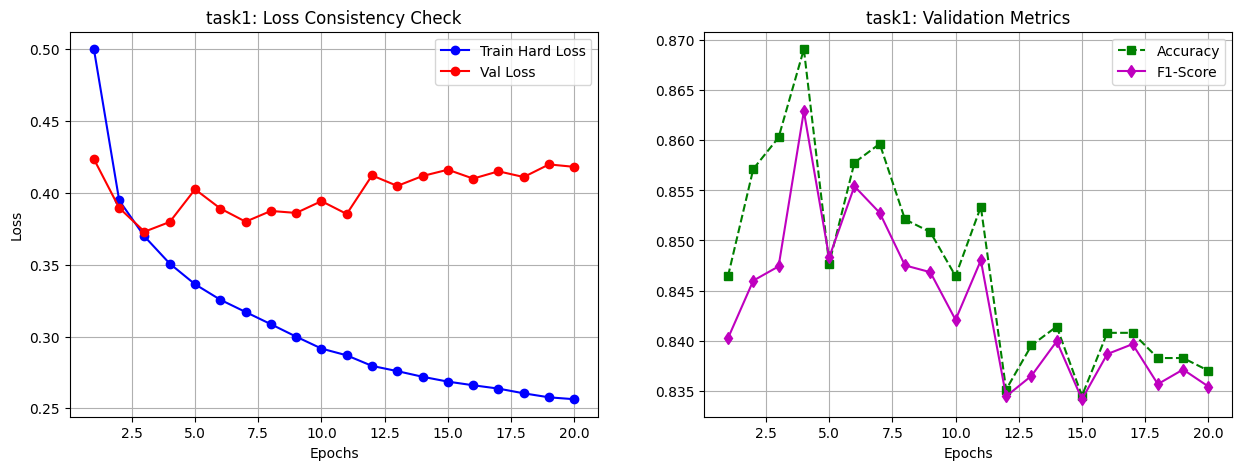

In [7]:
print("--- TRAINING TASK 1 (Binary: Spam vs Non-Spam) ---")
# Load Data
train_ds_t1 = ViSpamDatasetMultiTask(f"{ARGS['data_dir']}/train.csv", tokenizer, ARGS['max_seq_len'], task_type='task1')
dev_ds_t1 = ViSpamDatasetMultiTask(f"{ARGS['data_dir']}/dev.csv", tokenizer, ARGS['max_seq_len'], task_type='task1')
train_loader_t1 = DataLoader(train_ds_t1, batch_size=ARGS['batch_size'], shuffle=True)
dev_loader_t1 = DataLoader(dev_ds_t1, batch_size=ARGS['batch_size'])

# Run Training (use_focal_loss=False)
model_task1 = run_task_training("task1", 2, train_loader_t1, dev_loader_t1, use_focal_loss=False)

--- TRAINING TASK 2 (Categorization - Imbalanced) ---


INFO:__main__:=== START TRAINING TASK2 ===


[Task 2] Loaded 3777 samples (Spam only).
[Task 2] Loaded 407 samples (Spam only).


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ngcanh/sentiment-spam-phobert and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[task2] Using Focal Loss & Class Weights for BOTH Train and Val


Epoch 1:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 1: Train Hard Loss: 0.6107 | Val Loss: 0.4554 | F1: 0.1391


Epoch 2:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 2: Train Hard Loss: 0.4263 | Val Loss: 0.3600 | F1: 0.6484


Epoch 3:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 3: Train Hard Loss: 0.2814 | Val Loss: 0.3305 | F1: 0.7160


Epoch 4:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 4: Train Hard Loss: 0.2123 | Val Loss: 0.2946 | F1: 0.7333


Epoch 5:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 5: Train Hard Loss: 0.1754 | Val Loss: 0.3039 | F1: 0.7336


Epoch 6:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 6: Train Hard Loss: 0.1532 | Val Loss: 0.2910 | F1: 0.7855


Epoch 7:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 7: Train Hard Loss: 0.1270 | Val Loss: 0.2894 | F1: 0.8110


Epoch 8:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 8: Train Hard Loss: 0.1121 | Val Loss: 0.2673 | F1: 0.7921


Epoch 9:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 9: Train Hard Loss: 0.0988 | Val Loss: 0.2834 | F1: 0.7956


Epoch 10:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 10: Train Hard Loss: 0.0872 | Val Loss: 0.3191 | F1: 0.8230


Epoch 11:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 11: Train Hard Loss: 0.0789 | Val Loss: 0.2878 | F1: 0.8345


Epoch 12:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 12: Train Hard Loss: 0.0749 | Val Loss: 0.3177 | F1: 0.8320


Epoch 13:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 13: Train Hard Loss: 0.0715 | Val Loss: 0.2990 | F1: 0.8368


Epoch 14:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 14: Train Hard Loss: 0.0679 | Val Loss: 0.3022 | F1: 0.8389


Epoch 15:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 15: Train Hard Loss: 0.0658 | Val Loss: 0.3122 | F1: 0.8395


Epoch 16:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 16: Train Hard Loss: 0.0628 | Val Loss: 0.3274 | F1: 0.8225


Epoch 17:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 17: Train Hard Loss: 0.0633 | Val Loss: 0.3277 | F1: 0.8366


Epoch 18:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 18: Train Hard Loss: 0.0623 | Val Loss: 0.3201 | F1: 0.8215


Epoch 19:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 19: Train Hard Loss: 0.0603 | Val Loss: 0.3276 | F1: 0.8319


Epoch 20:   0%|          | 0/119 [00:00<?, ?it/s]

Ep 20: Train Hard Loss: 0.0592 | Val Loss: 0.3247 | F1: 0.8319


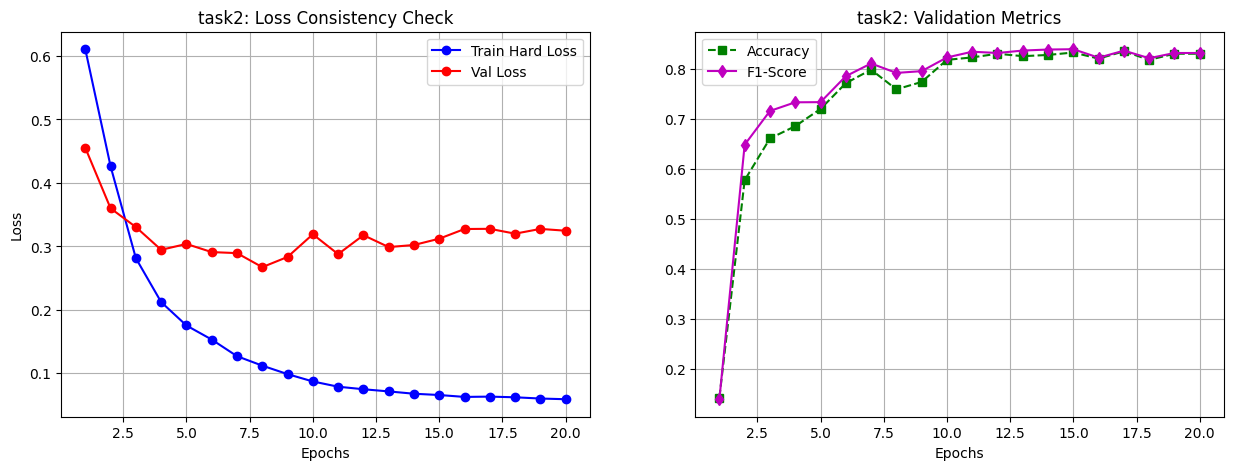

In [8]:
print("--- TRAINING TASK 2 (Categorization - Imbalanced) ---")
train_ds_t2 = ViSpamDatasetMultiTask(f"{ARGS['data_dir']}/train.csv", tokenizer, ARGS['max_seq_len'], task_type='task2')
dev_ds_t2 = ViSpamDatasetMultiTask(f"{ARGS['data_dir']}/dev.csv", tokenizer, ARGS['max_seq_len'], task_type='task2')
train_loader_t2 = DataLoader(train_ds_t2, batch_size=ARGS['batch_size'], shuffle=True)
dev_loader_t2 = DataLoader(dev_ds_t2, batch_size=ARGS['batch_size'])

# use_focal_loss=True -> Cả Train và Val đều dùng Focal Loss
model_task2 = run_task_training("task2", 3, train_loader_t2, dev_loader_t2, use_focal_loss=True)

In [9]:
# --- CELL BỔ SUNG: ĐỊNH NGHĨA DATASET TEST ---
class ViSpamFinalTestDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_len, mode='all'):
        self.df = pd.read_csv(data_path)
        
        # Mode 'all': Lấy hết (dùng cho Task 1 và Pipeline)
        if mode == 'all':
            self.df = self.df.dropna(subset=['clean_comment', 'label'])
        
        # Mode 'spam_only': Chỉ lấy Spam (dùng để test riêng sức mạnh Task 2)
        elif mode == 'spam_only':
            self.df = self.df[self.df['label'] == 1].dropna(subset=['clean_comment', 'spam_label'])
            self.df = self.df.reset_index(drop=True)
            
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = self.df.clean_comment.values
        self.labels = self.df.label.values.astype(int)
        # Fillna 0 để tránh lỗi (Non-spam không có spam_label)
        self.spam_labels = self.df.spam_label.fillna(0).values.astype(int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        spam_label = self.spam_labels[index]

        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_token_type_ids=True,
            return_attention_mask=True, return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
            'spam_label': torch.tensor(spam_label, dtype=torch.long)
        }

In [10]:
# --- CELL BỔ SUNG: KIỂM TRA HIỆU QUẢ CẢI TIẾN ---
from sklearn.metrics import classification_report

# 1. Load lại model tốt nhất vừa train
print("Loading Best Models...")
m1 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=2).to(device)
m1.load_state_dict(torch.load("best_student_task1.pth"))
m1.eval()

m2 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=3).to(device)
m2.load_state_dict(torch.load("best_student_task2.pth"))
m2.eval()

# 2. Test riêng Task 2 (Oracle Test)
print("\n>>> CHECKING TASK 2 IMPROVEMENT (Focal Loss Effect)...")
test_ds_spam = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='spam_only')
loader_spam = DataLoader(test_ds_spam, batch_size=32)

y_true, y_pred = [], []
with torch.no_grad():
    for batch in loader_spam:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        # Label gốc: 1,2,3 -> map về 0,1,2
        truth = batch['spam_label'].numpy() - 1
        
        out = m2(input_ids, attention_mask, token_type_ids)
        pred = torch.argmax(out['logits'], dim=1).cpu().numpy()
        
        y_true.extend(truth)
        y_pred.extend(pred)

print(classification_report(y_true, y_pred, target_names=["Spam-1", "Spam-2", "Spam-3"], digits=4))

Loading Best Models...

>>> CHECKING TASK 2 IMPROVEMENT (Focal Loss Effect)...
              precision    recall  f1-score   support

      Spam-1     0.3626    0.6111    0.4552        54
      Spam-2     0.8006    0.9094    0.8515       309
      Spam-3     0.9590    0.8491    0.9007       689

    accuracy                         0.8546      1052
   macro avg     0.7074    0.7899    0.7358      1052
weighted avg     0.8819    0.8546    0.8634      1052



Running Advanced Pipeline (Threshold = 0.7)...


Pipeline Testing:   0%|          | 0/124 [00:00<?, ?it/s]


=== FINAL ADVANCED PIPELINE REPORT ===
              precision    recall  f1-score   support

    Non-Spam     0.8453    0.9852    0.9099      2911
      Spam-1     0.3333    0.1667    0.2222        54
      Spam-2     0.4789    0.1100    0.1789       309
      Spam-3     0.9513    0.6517    0.7735       689

    accuracy                         0.8478      3963
   macro avg     0.6522    0.4784    0.5211      3963
weighted avg     0.8282    0.8478    0.8198      3963



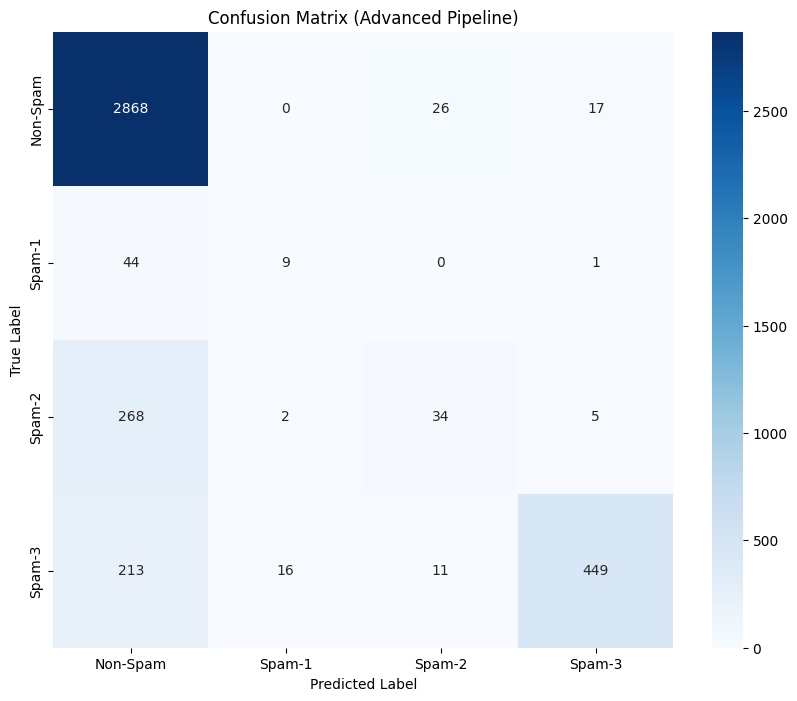

In [11]:
# --- CELL E: FINAL ADVANCED PIPELINE ---
def pipeline_predict_advanced(model1, model2, dataloader, threshold=0.7):
    model1.eval()
    model2.eval()
    final_preds = []
    true_labels = [] 
    
    print(f"Running Advanced Pipeline (Threshold = {threshold})...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Pipeline Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            
            # Lấy spam_label (0,1,2,3) làm Ground Truth
            labels = batch['spam_label'].cpu().numpy()
            
            # --- TASK 1: DETECT ---
            out1 = model1(input_ids, attention_mask, token_type_ids)
            probs1 = F.softmax(out1['logits'], dim=1)
            spam_probs = probs1[:, 1] # Xác suất là Spam
            
            batch_preds = []
            for i, prob in enumerate(spam_probs):
                # Logic: Chỉ khi xác suất > 0.7 mới nhận là Spam
                if prob < threshold:
                    batch_preds.append(0) # Non-spam
                else:
                    # --- TASK 2: CATEGORIZE ---
                    out2 = model2(
                        input_ids[i].unsqueeze(0), 
                        attention_mask[i].unsqueeze(0), 
                        token_type_ids[i].unsqueeze(0)
                    )
                    pred2 = torch.argmax(out2['logits'], dim=1).item()
                    batch_preds.append(pred2 + 1) # 0,1,2 -> 1,2,3
            
            final_preds.extend(batch_preds)
            true_labels.extend(labels)

    return true_labels, final_preds

# Load Data 'all'
test_ds_adv = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader_adv = DataLoader(test_ds_adv, batch_size=32)

# Chạy Inference
y_true_final, y_pred_final = pipeline_predict_advanced(m1, m2, test_loader_adv, threshold=0.7)

print("\n=== FINAL ADVANCED PIPELINE REPORT ===")
print(classification_report(y_true_final, y_pred_final, target_names=["Non-Spam", "Spam-1", "Spam-2", "Spam-3"], digits=4))

# Vẽ Matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Spam", "Spam-1", "Spam-2", "Spam-3"], yticklabels=["Non-Spam", "Spam-1", "Spam-2", "Spam-3"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Advanced Pipeline)')
plt.show()


=== EVALUATING TASK 1: BINARY SPAM DETECTION ===
Loaded best_student_task1.pth


Task 1 Eval:   0%|          | 0/124 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Non-Spam     0.8760    0.9485    0.9108      2911
        Spam     0.8150    0.6283    0.7096      1052

    accuracy                         0.8635      3963
   macro avg     0.8455    0.7884    0.8102      3963
weighted avg     0.8598    0.8635    0.8574      3963



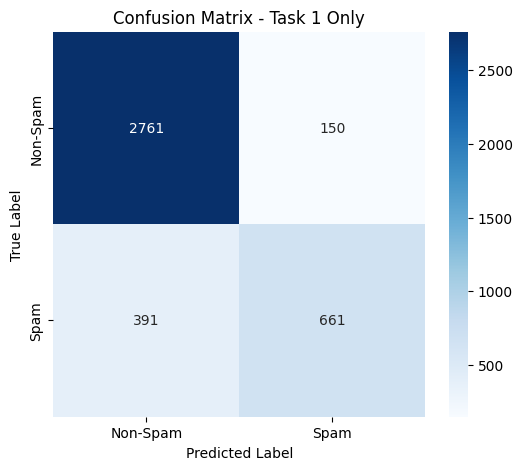

In [12]:
# --- EVALUATE TASK 1: SPAM DETECTION (Binary) ---
print("\n=== EVALUATING TASK 1: BINARY SPAM DETECTION ===")

# 1. Load dữ liệu Test (chế độ 'all' để lấy cả Spam và Non-spam)
test_ds_t1 = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader_t1 = DataLoader(test_ds_t1, batch_size=32)

# 2. Load Model Task 1 tốt nhất
model_t1 = TinyPhoBERT(
    AutoConfig.from_pretrained(ARGS["teacher_model"]), 
    ARGS["student_layers"], 
    ARGS["student_hidden_size"], 
    num_labels=2
).to(device)

if os.path.exists("best_student_task1.pth"):
    model_t1.load_state_dict(torch.load("best_student_task1.pth"))
    print("Loaded best_student_task1.pth")
else:
    print("Warning: Checkpoint not found, using current weights!")

model_t1.eval()

# 3. Chạy dự đoán
y_true_t1 = []
y_pred_t1 = []

with torch.no_grad():
    for batch in tqdm(test_loader_t1, desc="Task 1 Eval"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        # Lấy nhãn 0/1 (label)
        labels = batch['label'].cpu().numpy()

        outputs = model_t1(input_ids, attention_mask, token_type_ids)
        # Task 1 chỉ cần argmax (hoặc threshold > 0.5) để đánh giá sơ bộ
        preds = torch.argmax(outputs['logits'], dim=1).cpu().numpy()

        y_true_t1.extend(labels)
        y_pred_t1.extend(preds)

# 4. Báo cáo kết quả
print(classification_report(y_true_t1, y_pred_t1, target_names=["Non-Spam", "Spam"], digits=4))

# Vẽ Confusion Matrix cho Task 1
cm = confusion_matrix(y_true_t1, y_pred_t1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Spam", "Spam"], 
            yticklabels=["Non-Spam", "Spam"])
plt.title('Confusion Matrix - Task 1 Only')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

# --- 1. HÀM PREDICT VỚI THRESHOLD TÙY CHỈNH ---
def test_threshold_pipeline(model1, model2, dataloader, threshold):
    model1.eval()
    model2.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            
            # Lấy nhãn gốc (0,1,2,3)
            if 'spam_label' in batch:
                labels = batch['spam_label'].cpu().numpy()
            else:
                # Fallback nếu dùng loader cũ
                labels = batch['label'].cpu().numpy() 
            
            # --- TASK 1: DETECT ---
            out1 = model1(input_ids, attention_mask, token_type_ids)
            # Lấy xác suất lớp Spam (lớp 1)
            probs = F.softmax(out1['logits'], dim=1)[:, 1]
            
            batch_preds = []
            for i, p in enumerate(probs):
                # NẾU xác suất spam > threshold => coi là Spam => Đưa qua Task 2
                if p > threshold:
                    # --- TASK 2: CATEGORIZE ---
                    out2 = model2(
                        input_ids[i].unsqueeze(0), 
                        attention_mask[i].unsqueeze(0), 
                        token_type_ids[i].unsqueeze(0)
                    )
                    pred2 = torch.argmax(out2['logits'], dim=1).item()
                    batch_preds.append(pred2 + 1) # 0,1,2 -> 1,2,3
                else:
                    # Nếu < threshold => Non-spam
                    batch_preds.append(0)
            
            y_true.extend(labels)
            y_pred.extend(batch_preds)
            
    return y_true, y_pred

# --- 2. LOAD LẠI MODEL & DATA ---
print("Loading Best Models...")
# Task 1 Model
m1 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=2).to(device)
if os.path.exists("best_student_task1.pth"):
    m1.load_state_dict(torch.load("best_student_task1.pth"))
else:
    print("Warning: Chưa có best_student_task1.pth, dùng weight ngẫu nhiên!")

# Task 2 Model
m2 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=3).to(device)
if os.path.exists("best_student_task2.pth"):
    m2.load_state_dict(torch.load("best_student_task2.pth"))
else:
    print("Warning: Chưa có best_student_task2.pth!")

# Load Data Test
test_ds = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader = DataLoader(test_ds, batch_size=32)

# --- 3. CHẠY TEST VỚI CÁC NGƯỠNG KHÁC NHAU ---
# Thử các mức: 0.1 (Rất lỏng), 0.3 (Trung bình), 0.5 (Mặc định)
thresholds_to_test = [0.1, 0.3, 0.5, 0.7]

print(f"\n{'='*20} BẮT ĐẦU TEST CHỮA CHÁY {'='*20}")
for thr in thresholds_to_test:
    print(f"\n>>> Testing with Threshold = {thr} (Task 1 nhạy hơn)")
    y_true, y_pred = test_threshold_pipeline(m1, m2, test_loader, threshold=thr)
    
    # Chỉ in dòng kết quả của các loại Spam để so sánh nhanh
    print(classification_report(y_true, y_pred, target_names=["Non-Spam", "Spam-1", "Spam-2", "Spam-3"], digits=4))
    print("-" * 60)

Loading Best Models...

==================== BẮT ĐẦU TEST CHỮA CHÁY ====================

>>> Testing with Threshold = 0.1 (Task 1 nhạy hơn)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Non-Spam     0.0000    0.0000    0.0000      2911
      Spam-1     0.0590    0.6111    0.1077        54
      Spam-2     0.1320    0.9094    0.2306       309
      Spam-3     0.4585    0.8491    0.5954       689

    accuracy                         0.2268      3963
   macro avg     0.1624    0.5924    0.2334      3963
weighted avg     0.0908    0.2268    0.1230      3963

------------------------------------------------------------

>>> Testing with Threshold = 0.3 (Task 1 nhạy hơn)
              precision    recall  f1-score   support

    Non-Spam     0.9221    0.8574    0.8886      2911
      Spam-1     0.2391    0.4074    0.3014        54
      Spam-2     0.3541    0.5696    0.4367       309
      Spam-3     0.8351    0.8084    0.8215       689

    accuracy                         0.8203      3963
   macro avg     0.5876    0.6607    0.6121      3963
weighted avg     0.8533    0.8203    0.8337      3963

-----------------


=== EVALUATING TASK 1: BINARY SPAM DETECTION ===
Loaded best_student_task1.pth


Task 1 Eval:   0%|          | 0/124 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Non-Spam     0.8760    0.9485    0.9108      2911
        Spam     0.8150    0.6283    0.7096      1052

    accuracy                         0.8635      3963
   macro avg     0.8455    0.7884    0.8102      3963
weighted avg     0.8598    0.8635    0.8574      3963



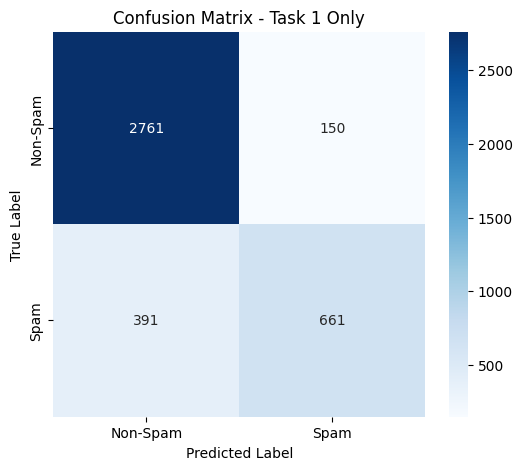

In [14]:
# --- EVALUATE TASK 1: SPAM DETECTION (Binary) ---
print("\n=== EVALUATING TASK 1: BINARY SPAM DETECTION ===")

# 1. Load dữ liệu Test (chế độ 'all' để lấy cả Spam và Non-spam)
test_ds_t1 = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader_t1 = DataLoader(test_ds_t1, batch_size=32)

# 2. Load Model Task 1 tốt nhất
model_t1 = TinyPhoBERT(
    AutoConfig.from_pretrained(ARGS["teacher_model"]), 
    ARGS["student_layers"], 
    ARGS["student_hidden_size"], 
    num_labels=2
).to(device)

if os.path.exists("best_student_task1.pth"):
    model_t1.load_state_dict(torch.load("best_student_task1.pth"))
    print("Loaded best_student_task1.pth")
else:
    print("Warning: Checkpoint not found, using current weights!")

model_t1.eval()

# 3. Chạy dự đoán
y_true_t1 = []
y_pred_t1 = []

with torch.no_grad():
    for batch in tqdm(test_loader_t1, desc="Task 1 Eval"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        # Lấy nhãn 0/1 (label)
        labels = batch['label'].cpu().numpy()

        outputs = model_t1(input_ids, attention_mask, token_type_ids)
        # Task 1 chỉ cần argmax (hoặc threshold > 0.5) để đánh giá sơ bộ
        preds = torch.argmax(outputs['logits'], dim=1).cpu().numpy()

        y_true_t1.extend(labels)
        y_pred_t1.extend(preds)

# 4. Báo cáo kết quả
print(classification_report(y_true_t1, y_pred_t1, target_names=["Non-Spam", "Spam"], digits=4))

# Vẽ Confusion Matrix cho Task 1
cm = confusion_matrix(y_true_t1, y_pred_t1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Spam", "Spam"], 
            yticklabels=["Non-Spam", "Spam"])
plt.title('Confusion Matrix - Task 1 Only')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

# --- 1. HÀM PREDICT VỚI THRESHOLD TÙY CHỈNH ---
def test_threshold_pipeline(model1, model2, dataloader, threshold):
    model1.eval()
    model2.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            
            # Lấy nhãn gốc (0,1,2,3)
            if 'spam_label' in batch:
                labels = batch['spam_label'].cpu().numpy()
            else:
                # Fallback nếu dùng loader cũ
                labels = batch['label'].cpu().numpy() 
            
            # --- TASK 1: DETECT ---
            out1 = model1(input_ids, attention_mask, token_type_ids)
            # Lấy xác suất lớp Spam (lớp 1)
            probs = F.softmax(out1['logits'], dim=1)[:, 1]
            
            batch_preds = []
            for i, p in enumerate(probs):
                # NẾU xác suất spam > threshold => coi là Spam => Đưa qua Task 2
                if p > threshold:
                    # --- TASK 2: CATEGORIZE ---
                    out2 = model2(
                        input_ids[i].unsqueeze(0), 
                        attention_mask[i].unsqueeze(0), 
                        token_type_ids[i].unsqueeze(0)
                    )
                    pred2 = torch.argmax(out2['logits'], dim=1).item()
                    batch_preds.append(pred2 + 1) # 0,1,2 -> 1,2,3
                else:
                    # Nếu < threshold => Non-spam
                    batch_preds.append(0)
            
            y_true.extend(labels)
            y_pred.extend(batch_preds)
            
    return y_true, y_pred

# --- 2. LOAD LẠI MODEL & DATA ---
print("Loading Best Models...")
# Task 1 Model
m1 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=2).to(device)
if os.path.exists("best_student_task1.pth"):
    m1.load_state_dict(torch.load("best_student_task1.pth"))
else:
    print("Warning: Chưa có best_student_task1.pth, dùng weight ngẫu nhiên!")

# Task 2 Model
m2 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=3).to(device)
if os.path.exists("best_student_task2.pth"):
    m2.load_state_dict(torch.load("best_student_task2.pth"))
else:
    print("Warning: Chưa có best_student_task2.pth!")

# Load Data Test
test_ds = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader = DataLoader(test_ds, batch_size=32)

# --- 3. CHẠY TEST VỚI CÁC NGƯỠNG KHÁC NHAU ---
# Thử các mức: 0.1 (Rất lỏng), 0.3 (Trung bình), 0.5 (Mặc định)
thresholds_to_test = [0.1, 0.3, 0.5, 0.7]

print(f"\n{'='*20} BẮT ĐẦU TEST CHỮA CHÁY {'='*20}")
for thr in thresholds_to_test:
    print(f"\n>>> Testing with Threshold = {thr} (Task 1 nhạy hơn)")
    y_true, y_pred = test_threshold_pipeline(m1, m2, test_loader, threshold=thr)
    
    # Chỉ in dòng kết quả của các loại Spam để so sánh nhanh
    print(classification_report(y_true, y_pred, target_names=["Non-Spam", "Spam-1", "Spam-2", "Spam-3"], digits=4))
    print("-" * 60)

Loading Best Models...

==================== BẮT ĐẦU TEST CHỮA CHÁY ====================

>>> Testing with Threshold = 0.1 (Task 1 nhạy hơn)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Non-Spam     0.0000    0.0000    0.0000      2911
      Spam-1     0.0590    0.6111    0.1077        54
      Spam-2     0.1320    0.9094    0.2306       309
      Spam-3     0.4585    0.8491    0.5954       689

    accuracy                         0.2268      3963
   macro avg     0.1624    0.5924    0.2334      3963
weighted avg     0.0908    0.2268    0.1230      3963

------------------------------------------------------------

>>> Testing with Threshold = 0.3 (Task 1 nhạy hơn)
              precision    recall  f1-score   support

    Non-Spam     0.9221    0.8574    0.8886      2911
      Spam-1     0.2391    0.4074    0.3014        54
      Spam-2     0.3541    0.5696    0.4367       309
      Spam-3     0.8351    0.8084    0.8215       689

    accuracy                         0.8203      3963
   macro avg     0.5876    0.6607    0.6121      3963
weighted avg     0.8533    0.8203    0.8337      3963

-----------------

In [16]:
import time
import os
import torch
from tqdm.notebook import tqdm

def evaluate_performance(model, dataloader, model_path, device):
    model.eval()
    
    print("-" * 30)
    print("📊 MODEL PERFORMANCE REPORT")
    print("-" * 30)

    # 1. Đo Model Size (Storage - MB)
    if os.path.exists(model_path):
        size_mb = os.path.getsize(model_path) / (1024 * 1024)
        print(f"💾 Storage Size: {size_mb:.2f} MB")
    else:
        print("⚠️ File model chưa được lưu, bỏ qua tính Storage Size.")

    # 2. Đo Số lượng tham số (Parameters Count)
    # Tổng số tham số
    total_params = sum(p.numel() for p in model.parameters())
    # Số tham số huấn luyện được (Trainable) - quan trọng nếu bạn đóng băng (freeze) một số lớp
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"🧠 Total Parameters: {total_params:,} ({total_params/1e6:.1f}M)")
    print(f"🔥 Trainable Params: {trainable_params:,} ({trainable_params/1e6:.1f}M)")

    # 3. Đo Inference Time
    print("\n🚀 Measuring Latency & Throughput...")
    # Warmup
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 5: break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            _ = model(input_ids, attention_mask, token_type_ids)
    
    # Đo thực tế
    total_time = 0
    num_samples = 0
    
    with torch.no_grad():
        start_time = time.time()
        for batch in tqdm(dataloader, desc="Inferencing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            
            _ = model(input_ids, attention_mask, token_type_ids)
            num_samples += input_ids.shape[0]
            
        end_time = time.time()
        
    total_time = end_time - start_time
    avg_time_per_sample = (total_time / num_samples) * 1000 # ms
    samples_per_second = num_samples / total_time
    
    print(f"⚡ Latency: {avg_time_per_sample:.4f} ms/sample")
    print(f"🏎️ Throughput: {samples_per_second:.2f} samples/sec")
    print("-" * 30)
    
    return total_params, avg_time_per_sample

In [17]:
# Cấu hình lại DataLoader (Batch size = 1 để đo Latency chuẩn nhất)
test_ds_perf = ViSpamFinalTestDataset(f"{ARGS['data_dir']}/test.csv", tokenizer, ARGS['max_seq_len'], mode='all')
test_loader_perf = DataLoader(test_ds_perf, batch_size=1) 

# --- TASK 1 ---
print("\n>>> EVALUATING TASK 1 MODEL")
m1 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=2).to(device)
if os.path.exists("best_student_task1.pth"):
    m1.load_state_dict(torch.load("best_student_task1.pth"))
    evaluate_performance(m1, test_loader_perf, "best_student_task1.pth", device)

# --- TASK 2 ---
print("\n>>> EVALUATING TASK 2 MODEL")
m2 = TinyPhoBERT(AutoConfig.from_pretrained(ARGS["teacher_model"]), ARGS["student_layers"], ARGS["student_hidden_size"], num_labels=3).to(device)
if os.path.exists("best_student_task2.pth"):
    m2.load_state_dict(torch.load("best_student_task2.pth"))
    evaluate_performance(m2, test_loader_perf, "best_student_task2.pth", device)


>>> EVALUATING TASK 1 MODEL
------------------------------
📊 MODEL PERFORMANCE REPORT
------------------------------
💾 Storage Size: 113.09 MB
🧠 Total Parameters: 29,637,146 (29.6M)
🔥 Trainable Params: 29,637,146 (29.6M)

🚀 Measuring Latency & Throughput...


Inferencing:   0%|          | 0/3963 [00:00<?, ?it/s]

⚡ Latency: 4.3725 ms/sample
🏎️ Throughput: 228.70 samples/sec
------------------------------

>>> EVALUATING TASK 2 MODEL
------------------------------
📊 MODEL PERFORMANCE REPORT
------------------------------
💾 Storage Size: 113.09 MB
🧠 Total Parameters: 29,637,459 (29.6M)
🔥 Trainable Params: 29,637,459 (29.6M)

🚀 Measuring Latency & Throughput...


Inferencing:   0%|          | 0/3963 [00:00<?, ?it/s]

⚡ Latency: 4.3781 ms/sample
🏎️ Throughput: 228.41 samples/sec
------------------------------
